In [36]:
import joblib

In [37]:
import os
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [38]:
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0,rpath)
from src.plots import Plot
from src.preprocessing import PreProcess

In [39]:
kmeans = joblib.load('../models/kmeans_model.pkl')

In [40]:
df = pd.read_csv('../data/cleaned_data_outliers.csv')
df['avg_tcp_retrans'] = df['tcp_dl_retrans._vol_(bytes)'] + df['tcp_ul_retrans._vol_(bytes)']
df['avg_rrt'] = df['avg_rtt_dl_(ms)'] + df['avg_rtt_dl_(ms)']
df['avg_bearer_tp'] = df['avg_bearer_tp_dl_(kbps)'] + df['avg_bearer_tp_ul_(kbps)']

In [41]:
column_name = 'msisdn/number'
value_to_match = 33663706799.0
mask = df[column_name] == value_to_match
df = df[~mask]

In [42]:
preprocess = PreProcess(df)

In [43]:
agg_data = df.groupby('msisdn/number').agg({'avg_tcp_retrans':sum,'avg_rrt':sum,'avg_bearer_tp':sum})
preprocess.replace_neg_inf_with_mean(agg_data)

,avg_tcp_retrans,avg_rrt,avg_bearer_tp
msisdn/number,,,
3.360100e+10,23.201031,7.657283,7.274480
3.360100e+10,23.201031,6.802395,7.803027
3.360100e+10,23.201031,7.613325,7.763021
3.360101e+10,16.921539,8.468213,9.102310
3.360101e+10,49.213729,15.573104,27.135851
...,...,...,...
3.379000e+10,20.285299,7.475339,15.166563
3.379000e+10,23.201031,7.052721,8.090709
3.197021e+12,23.201031,7.613325,16.089721


**Experience score to each user**

In [44]:
from sklearn.preprocessing import StandardScaler

In [45]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(agg_data[['avg_tcp_retrans','avg_rrt','avg_bearer_tp']])

In [46]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(cluster_centers, columns=['avg_tcp_retrans','avg_rrt','avg_bearer_tp'])

In [47]:
print("Cluster Centers:")
print(centroid_df)

Cluster Centers:
   avg_tcp_retrans    avg_rrt  avg_bearer_tp
0        22.803067   7.940064      11.011754
1        49.151734  16.482872      24.187841
2       103.877151  35.805388      63.802692


In [50]:
from sklearn.metrics.pairwise import euclidean_distances

# Calculate Euclidean distances between each user and the centroids
distances = euclidean_distances(scaled_features, cluster_centers)

# Find the cluster index for the less engaged cluster (assuming Cluster 0 is less engaged)
less_engaged_cluster_index = 0

# Extract the distances for the less engaged cluster
engagement_scores = distances[:, less_engaged_cluster_index]

# Add the engagement scores to the DataFrame
agg_data['Engagement_Score'] = engagement_scores


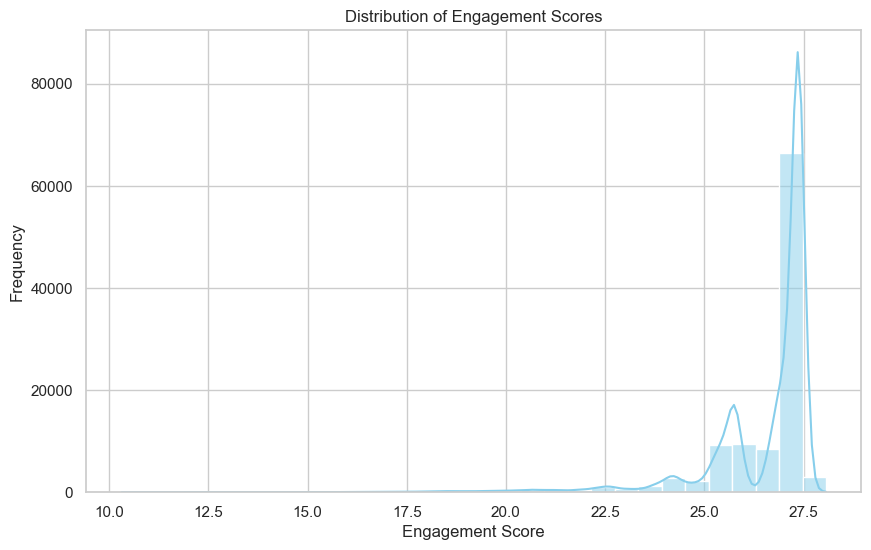

In [51]:
# Set the style for better visualization
sns.set(style="whitegrid")

# Create a histogram of engagement scores
plt.figure(figsize=(10, 6))
sns.histplot(agg_data['Engagement_Score'], bins=30, kde=True, color='skyblue')

# Set plot labels and title
plt.xlabel('Engagement Score')
plt.ylabel('Frequency')
plt.title('Distribution of Engagement Scores')

# Display the plot
plt.show()


This is what we call left skewed, which suggests that there are fewer users with lower experience score, while a significant proportion of users has higher experience scores.